In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rand



def mandelbrot(xmin, xmax, ymin, ymax, xiter, yiter, limit):
    a_step = 0

    pixel_list = np.ndarray((xiter + 2, yiter + 2))

    for a in np.linspace(xmin, xmax, xiter):
        a_step += 1
        b_step = 0
        for b in np.linspace(ymin, ymax, yiter):
            b_step += 1
            z_0 = complex(a, b)
            z = z_0
            counter = 0

            while abs(z) < 2 and counter < limit:
                z = z ** 2 + z_0
                counter += 1
                
            pixel_list[b_step][a_step] = counter
    

    return pixel_list



In [2]:
xmin = -2
xmax = 0.5
ymin = -2
ymax = 2
xiter = 2000
yiter = 2000
limit = 250

pixel_list = mandelbrot(xmin, xmax, ymin, ymax, xiter, yiter, limit)


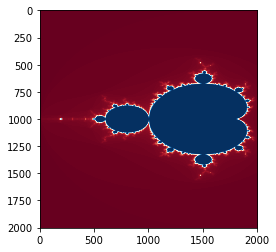

In [3]:
%matplotlib inline
plt.imshow(pixel_list, cmap='RdBu')
plt.show()


In [17]:
def check_converge(z_0, treshold=2, max_iterations=25):
    """
    Checks if the complex number z_0 converges within the max_iterations.
    """

    z = z_0
    counter = 0
    while True:
        z = z ** 2 + z_0
        counter += 1

        if abs(z) > 2:
            return False
        if counter > max_iterations:
            return True

def determine_area(i = 25, s=10000, sample_method="pure"):
    """
    Determine the area of the mandelbrot set.

    Parameters:
    i: int, Max number of iterations
    s: int, The number of sample points.
    sample_method: string, options are:
        'pure': pure random sampling,
        'hypercube': hypercube sampling,
        'orthogonal': orthogonal sampling
    """

    xmin = -2
    xmax = 1
    ymin = -2
    ymax = 2
    bounding_box_area = (xmax - xmin) * (ymax - ymin)

    if sample_method == "pure":
        Z = generate_sample_points_pure_random(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    elif sample_method == "hypercube":
        Z = generate_sample_points_hypercube(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    elif sample_method == "orthogonal":
        Z = generate_sample_points_orthogonal(s, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

    Z0 = Z

    N = np.zeros(s)

    for _ in range(i):
        Z = np.where(abs(Z) < 2, Z ** 2 + Z0, 100)

    N[Z != 100] = 1

    n_good_points = sum(N)
    
    return bounding_box_area * (n_good_points / s)

def plot_i_s_contour(i_list, s_list, log=False):
    """
    Plots the difference between the expected and calculated area for different values for i and s. 
    i is the maximum number of iterations and s is the number of samples. 
    """

    total_evaluations = len(i_list) * len(s_list)
    n_evaluations = 0

    expected_area = 1.506484

    data = []
    for i in i_list:

        results = []
        for s in s_list:
            results.append(determine_area(i=i, s=s) - expected_area)
            n_evaluations += 1

            if log and n_evaluations % 10 == 0:
                print(f"Progress: {n_evaluations/total_evaluations * 100:0f}%", end="\r")
        
        data.append(results)

    contour = plt.contourf(s_list, i_list, data, 10, cmap="PuBuGn_r")
    
    colorbar = plt.colorbar(contour)
    colorbar.set_label("Difference between expected area")

    plt.xlabel("Samples")
    plt.ylabel("Max iterations")

    plt.xscale("log")
    plt.yscale("log")
    plt.show()

def plot_i_s_variance(i_list, s_list, nruns=10, log=False):
    """
    Plots the variance of the difference between the expected and calculated area for different values for i and s. 
    i is the maximum number of iterations and s is the number of samples. 
    """
    
    total_evaluations = len(i_list) * len(s_list) * nruns
    n_evaluations = 0

    expected_area = 1.506484

    data = []
    for i in i_list:

        results = []
        for s in s_list:

            run_results = []
            for run in range(nruns):
                run_results.append(determine_area(i=i, s=s))
                n_evaluations += 1

                if log and n_evaluations % 10 == 0:
                    print(f"Progress: {n_evaluations/total_evaluations * 100:1f}%", end="\r")

            results.append(np.var(run_results))
        
        data.append(results)

    contour = plt.contourf(s_list, i_list, data, 10, cmap="PuBuGn_r")
    
    colorbar = plt.colorbar(contour)
    colorbar.set_label("Variance in area")

    plt.xlabel("Samples")
    plt.ylabel("Max iterations")

    plt.xscale("log")
    plt.yscale("log")
    plt.show()

def generate_sample_points_pure_random(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    
    X = rand.rand(s) * (xmax - xmin) + xmin
    Y = rand.rand(s) * (ymax - ymin) + ymin

    return X + Y * 1j

def generate_sample_points_hypercube(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    # TODO

    pass

def generate_sample_points_orthogonal(s=10000, xmin=-2, xmax=1, ymin=-2, ymax=2):
    # TODO

    pass

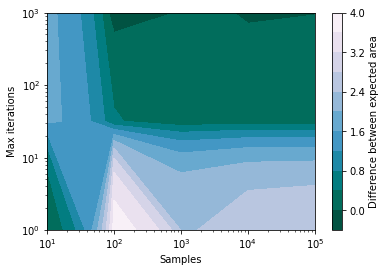

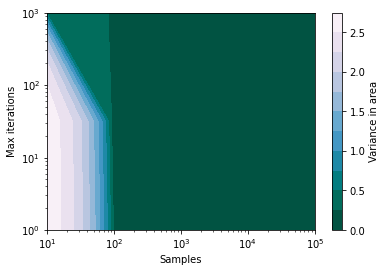

In [18]:
%matplotlib inline

i_list = np.logspace(0, 3, 3, dtype=int)
s_list = np.logspace(1, 5, 3, dtype=int)
plot_i_s_contour(i_list, s_list, log=True)
plot_i_s_variance(i_list, s_list, nruns=3, log=True)